In [190]:
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import scipy.stats as sps

from matplotlib import font_manager

import os
os.chdir('/Users/will/Repos/election-official-job-descriptions')

%config InlineBackend.figure_format = 'svg'
# plt.rcParams['figure.dpi'] = 200

fe = font_manager.FontEntry(
    fname='/Users/will/Library/Fonts/StyreneA-Black.otf',
    name='StyreneABlack')
font_manager.fontManager.ttflist.insert(0, fe) # or append is fine

fe = font_manager.FontEntry(
    fname='/Users/will/Library/Fonts/StyreneA-Medium.otf',
    name='StyreneAMedium')
font_manager.fontManager.ttflist.insert(0, fe) # or append is fine

fe = font_manager.FontEntry(
    fname='/Users/will/Library/Fonts/StyreneA-Regular.otf',
    name='StyreneARegular')
font_manager.fontManager.ttflist.insert(0, fe) # or append is fine



matplotlib.rcParams['font.family'] = 'StyreneARegular' # = 'your custom ttf font name'


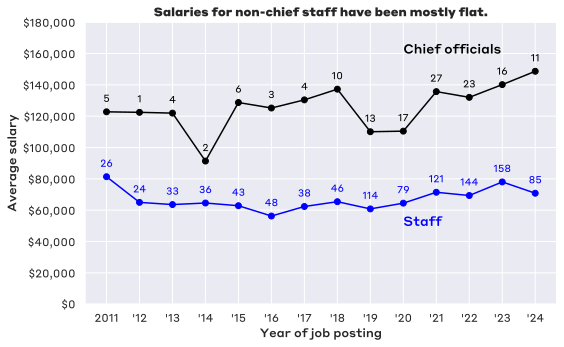

In [196]:
job_df = pd.read_csv('dataset.csv')
job_df = job_df[job_df['classification_experimental'] != 'not_election_official']

# Plot salary over time, split by top official

plt.figure(figsize=(8,5))

def plot_subset(df, color='black', salary_col='salary_mean'):
    salary_means = df.groupby('year')['salary_mean'].mean()
    year_counts = df.groupby('year').size()
    
    # Plot
    salary_means.plot(kind='line', marker='o', color=color)
    for year, (mean, count) in enumerate(zip(salary_means, year_counts)):
        plt.annotate(str(count), (salary_means.index[year], salary_means.iloc[year]),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center',
                     color=color,
                     size=10)
        
    # sns.lineplot(data=df, x="year", y="salary_mean") # for error bar

    return salary_means, year_counts
    
color='blue'
salary_nontop, counts_nontop = plot_subset(job_df[job_df['classification_experimental']!='top_election_official'], color=color)


plt.annotate('Staff', (2020, 50000), weight=800, size=13, color=color, font='StyreneAMedium')

color='black'
salary_top, counts_top = plot_subset(job_df[job_df['classification_experimental']=='top_election_official'], color=color)

plt.annotate('Chief officials', (2020, 160000), weight=800, size=13, color=color, font='StyreneAMedium')


# Define a custom y-axis tick formatter
def currency_formatter(x, pos):
    return "${:,.0f}".format(x)

# Apply the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Define a custom x-axis tick formatter
def year_formatter(x, pos):
    if x==2011:
        return 2011
    else:
        return f"'{str(x)[2:]}"


# Apply the custom formatter to the y-axis
plt.gca().xaxis.set_major_formatter(FuncFormatter(year_formatter))

plt.title('Salaries for non-chief staff have been mostly flat.', fontname='StyreneABlack')
plt.ylabel('Average salary', fontname='StyreneAMedium')
plt.xlabel('Year of job posting', fontname='StyreneAMedium')
plt.ylim([0, 180000])
plt.grid(True)

plt.tight_layout()
plt.xticks(range(2011, 2025), size=11)
plt.show()

In [78]:
counts_top.name = 'counts_top'
salary_top.name = 'salary_top'
counts_nontop.name = 'counts_nontop'
salary_nontop.name = 'salary_nontop'
# pd.merge(year_top, salary_top, year_nontop, left_index=True, right_index=True)
export = pd.concat([salary_top, counts_top, salary_nontop, counts_nontop], axis=1)

export.to_csv('export.csv')

In [79]:
export

,salary_top,counts_top,salary_nontop,counts_nontop
year,,,,
2011,122797.250000,5,81374.815789,26
2012,122472.000000,1,64993.498462,24
2013,121972.150000,4,63600.175200,33
2014,91372.500000,2,64587.861304,36
2015,128727.333333,6,62859.050556,43
2016,125221.000000,3,56276.760385,48
2017,130419.461250,4,62364.229655,38
2018,137255.562500,10,65426.260000,46
2019,110077.962273,13,60828.115353,114


In [6]:
def chop_after_county(s):
    s = str(s)
    if 'COUNTY' in s:
        return s[:s.find('COUNTY') + 6] # 6 is the length of the word 'county'
    else:
        return s


In [146]:
# analyze with population data

job_df['upper_county'] = job_df['employer'].str.upper().apply(chop_after_county)
job_df['upper_state'] = job_df['state'].str.upper()

pop = pd.read_csv('leo_population_2023.csv')

merged_df = pd.merge(job_df, pop[['jurisdiction', 'state', 'total_reg']],
                     left_on=['upper_county', 'upper_state'],
                     right_on=['jurisdiction', 'state'],
                     how='left')  # Use 'left' to keep all rows from job_df

salreg = merged_df[~merged_df['total_reg'].isna() & ~merged_df['salary_mean'].isna()]

nontop_geo = salreg[(salreg['pay_basis'].isin(['yearly', 'monthly'])) & (salreg['salary_mean'] > 10000) & (salreg['classification_experimental']!='top_election_official')]
print(len(nontop_geo)) # drops to just 362 points because of population matching, having a salary, etc.

top_geo = salreg[(salreg['pay_basis'].isin(['yearly', 'monthly'])) & (salreg['salary_mean'] > 10000) & (salreg['classification_experimental']=='top_election_official')]
print(len(top_geo)) # 36


326
36


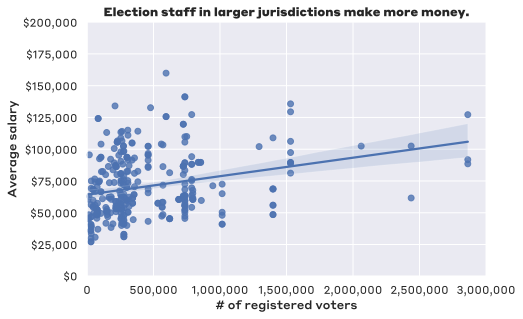

In [198]:
g = sns.jointplot(nontop_geo, x='total_reg', y='salary_mean', kind='reg', height=6)

g.ax_joint.set_xscale('linear') # linear or log
# g.ax_joint.set_xticks([1e4, 1e5, 1e6])
# g.ax_joint.set_xticklabels(['10,000', '100,000', '1,000,000'])
g.ax_joint.set_xlim([0, 3e6])
g.ax_joint.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
g.ax_joint.set_xlabel('# of registered voters', fontname='StyreneAMedium')

g.ax_joint.set_ylim([0, 2e5])
g.ax_joint.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: f'${format(int(x), ",")}'))
g.ax_joint.set_ylabel('Average salary', fontname='StyreneAMedium')

plt.title('Election staff in larger jurisdictions make more money.', fontname='StyreneABlack')

fig = plt.gcf()
fig.axes[2].remove()
fig.axes[1].remove()

fig.set_size_inches(8, 5)

In [171]:
v = dict(job_df.state.value_counts())

for k in dict(v):
    print(f'{k}: {v[k]}')

North Carolina: 129
Colorado: 107
California: 94
Washington: 86
Virginia: 84
Oregon: 52
Arizona: 50
Florida: 50
Texas: 46
Michigan: 43
Ohio: 35
Illinois: 33
Maryland: 33
Georgia: 28
Minnesota: 21
South Carolina: 16
United States: 15
New York: 14
Pennsylvania: 12
District of Columbia: 11
Nevada: 11
Idaho: 9
Washington, D.C.: 8
Massachusetts: 7
Wisconsin: 7
Utah: 7
Rhode Island: 6
New Mexico: 6
North Dakota: 6
Not provided: 6
Kansas: 5
Iowa: 4
Washington, DC: 4
Connecticut: 3
Vermont: 3
Kentucky: 2
Alabama: 2
West Virginia: 2
Tennessee: 2
Iraq: 2
Montana: 2
Missouri: 2
Maine: 1
Michigan and Arizona: 1
Indiana: 1
State of California: 1
Alaska: 1
Nebraska: 1
Nunavut, Canada: 1


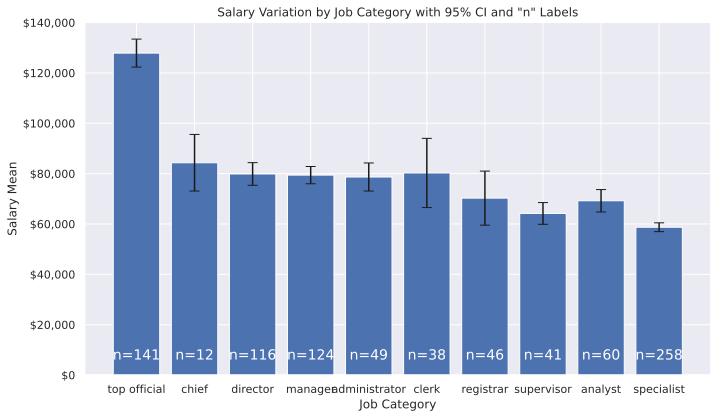

In [89]:
top_official = 'top official'
titles = ['chief', 'director', 'manager', 'administrator', 'clerk', 'registrar', 'supervisor', 'analyst', 'specialist']
for title in titles[::-1]: # reverse to prioritize catching the higher level jobs:
    job_df.loc[job_df['job_title'].str.lower().str.contains(title, na=False), 'seniority'] = title
job_df.loc[job_df['classification_experimental']=='top_election_official', 'seniority'] = top_official
titles = [top_official] + titles

    

category_order = pd.CategoricalDtype(categories=titles, ordered=True)
job_df['seniority'] = job_df['seniority'].astype(category_order)

# Group the data by 'Category' and calculate the mean and standard deviation of salaries
grouped_data = job_df.groupby('seniority', observed=True)['salary_mean'].agg(['mean', 'size', 'std']).reset_index()

grouped_data['ci'] = grouped_data.apply(lambda row: sps.t.interval(0.95, row['size'] - 1, loc=row['mean'], scale=row['std'] / (row['size'] ** 0.5)), axis=1)

# Extract lower and upper CI bounds
grouped_data['ci_lower'] = grouped_data['ci'].apply(lambda x: x[0])
grouped_data['ci_upper'] = grouped_data['ci'].apply(lambda x: x[1])


# Create the bar chart with 95% CI error bars and "n" labels
plt.figure(figsize=(10, 6))
bars = plt.bar(grouped_data['seniority'], grouped_data['mean'], yerr=[grouped_data['mean'] - grouped_data['ci_lower'], grouped_data['ci_upper'] - grouped_data['mean']], capsize=5)

# Add "n" labels on top of each bar
for bar, n in zip(bars, grouped_data['size']):
    plt.text(bar.get_x() + bar.get_width() / 2, 5000, f'n={n}', ha='center', va='bottom', fontsize=14, color='w')

plt.xlabel('Job Category')
plt.ylabel('Salary Mean')
plt.title('Salary Variation by Job Category with 95% CI and "n" Labels')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))

plt.show()
